# Solving Bloch Eigenproblems with FenicsX

Josh Tempelman

University of Illinois at Urbana Champaign

Copyright (c) 2023 Joshua R. Tempelman (jrt7@illinois.edu)


## About

This notebook provides a detailed tutorial on solving Bloch dispersion problems using the `dolfinx`, `dolfinx-mpc`, and `gmsh` modules. The functions herein are wrapped in the `fenonics` module provided at: https://github.com/jtempelman95/fenonics. 

## Problem Defintion:
Find the eigensolutions to the Bloch-periodic wave equation. We consider a domain $\Omega \in[0,a]\times[0,a]$, where $a$ is the characteristic unit cell length, that satisfies

\begin{align}
	& \ddot{u} - c^2\nabla^2 u  = 0\\
	&u(0,y) = u(a,y)e^{i k_xa} \ \ \text{on} \ 0<y<a\\
	&u(x,0) = u(x,a)e^{i k_ya} \ \ \text{on} \ 0<x<a
\end{align}

where the boundary conditions indicate the complex spatial phase of the Bloch ansatz.

In [3]:
# ################################################## #
# Genearal imports                                   #
# ################################################## #
import numpy as np
import matplotlib.pyplot as plt
import time

# ################################################## #
# Imports for plotting                               #
# ################################################## #
import matplotlib.pyplot as plt
from dolfinx.io import gmshio
import pyvista
pyvista.start_xvfb()

# ################################################## #
# Imports for the meshing                            #
# ################################################## #
import gmsh
from dolfinx.plot       import create_vtk_mesh
from dolfinx.io         import XDMFFile
from dolfinx.io.gmshio  import model_to_mesh
from dolfinx.io         import gmshio

# ################################################## #
# Imports for finite element modeling                #
# ################################################## #
from mpi4py import MPI
import dolfinx_mpc
import dolfinx
from dolfinx.fem    import Function, FunctionSpace
from dolfinx.mesh import locate_entities_boundary
from dolfinx.fem    import form
from dolfinx    import plot
from mpi4py     import MPI
from dolfinx    import fem
from ufl        import TrialFunction, TestFunction, grad, dx, dot,Argument,inner

from petsc4py.PETSc import ScalarType
from petsc4py   import PETSc
from scipy.sparse.linalg import eigsh
from scipy import sparse

## Define the parameters of the mesh

Here we set parameters of the problem. The first step is to pick a geometry of our 2D unit cell. This code currenlty supports square unit cells.

We define a vector $\textbf{r}$ as the design vector of a square unit cell. This corresponds to a vector of radii to define coordinates to fit a spline curve about. The $x_i$ and $y_i$ coordinates of each design point are determined   via $x_i = r_i\cos\theta_i$ and $y_i=r_i\sin\theta_i$, where $\theta_i$ ensures equidistant angles between design points.
The design points are confined to the subquadrant $0\leq\theta\leq\pi/(N/2)$, where $N$ is the number of quadrants that the geomtry is radially periodic about. E.g., if $N=1$, the there is one quadrant. If $N = 4$, there are 4.

Here is an example of a design vecotor that is rotated 4 times (Nquads = 3) and the spline curve that results from it

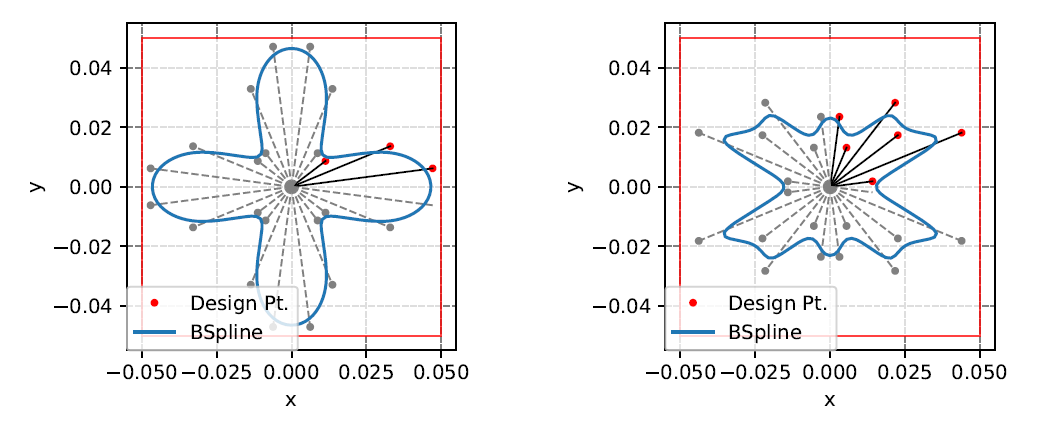

It is suggesgted to use 4-fold symmetry (Nquad  = 4) to reduce the number of high-symmetry points required to construct the dispersion diagrams



The `gmsh-api` will be used to genereate a mesh based on a set of input arguments. We have provided the `get_mesh` function which was imported from the `Mesh_Functions` module of the `fenonics` package. It takes the arguments:

    a   -            Charecterstic unit cell length (primitive basis)
    r        -           vector of points to fit spline to
    Nquads    -          Number of quadrants to repeat spline through (radially)
    offset     -         Offset angle for inclusion geometry
    iscut       -        Choose if inclusion is void or an filled
    refinement_level -   Choose how much denser mesh gets around refinement field
    refinement_dist  -   Maximum distance of refinement field from refined edges
    isrefined        -   Choose whether or not to refine mesh around internal edges
    meshalg          -   Meshing algorithm for gmsh to use

In [48]:
from fenonics.MeshFunctions import get_mesh

start = time.time()

# Set mesh parameters
a_len = .1
r = np.array([1,.1,.4])*a_len*.95
Nquads = 8
offset = 0
da  =   a_len/15
meshalg =   6
refinement_level =   3
refinement_dist =   a_len/10
isrefined = True  
cut = True        

# Generate the mesh
gmsh.model, xpt, ypt = get_mesh(
    a = a_len, 
    da = da,
    r = r,
    Nquads = Nquads,
    offset = offset,
    meshalg = meshalg,
    refinement_level = refinement_level,
    refinement_dist = refinement_dist,
    isrefined = isrefined, 
    cut = cut
)

t1 =  round(time.time()-start,3)
print('Generated Mesh in ' + str(t1)  + ' Seconds')    


Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.12809s, CPU 0.128791s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0336879s, CPU 0.034879s)
Info    : 1193 nodes 2367 elements
to here
Generated Mesh in 0.211 Seconds


### Visualizing the geometry
We can extract the spline curve from the `gsmh` object and check to see what this unit cell will look lile.

<module 'matplotlib.pyplot' from '/home/jrt7/anaconda3/envs/fenicsx-env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

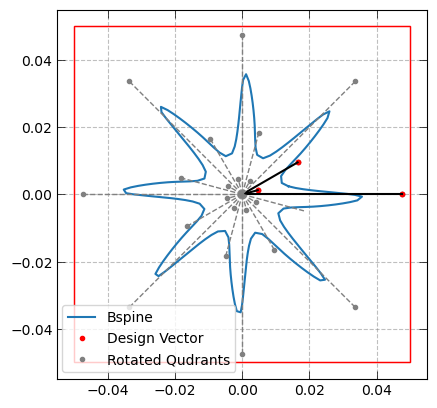

In [49]:
from matplotlib.patches  import Rectangle

def GetSpline(gmsh,a_len, xpt, ypt):   
    """
    Get spline geometry from gmsh mesh

    inputs:
        gmsh - the gmsh object
        a_len - charecterstic length of unit cell

    outputs:
        SpintPtDat - x-y points used for gmsh to generate spline curve
        SplineDat - x-y array of coordinates defining the spline curve
    """
    node_interior = gmsh.model.mesh.getNodesForPhysicalGroup(1,5)[1]
    x_int       = node_interior[0::3]
    y_int       = node_interior[1::3]
    x_int       = np.concatenate([x_int,[x_int[0]]])
    y_int       = np.concatenate([y_int,[y_int[0]]])
    xi          = x_int - a_len/2
    yi          = y_int - a_len/2
    lxi         = len(xi)
    lxp         = len(xpt)
    xptnd       = np.array(xpt) - a_len/2
    yptnd       = np.array(ypt)- a_len/2
    lxp         = len(xptnd)
    xsv         = np.empty(xi.shape)
    SplineDat   = np.hstack( (xi.reshape(lxi,1), yi.reshape(lxi,1) ))  
    SplinePtDat = np.hstack( (xptnd.reshape(lxp,1), yptnd.reshape(lxp,1) ))  
    return SplinePtDat, SplineDat

def PlotSpline(gmsh, r, Nquads, a_len, xpt, ypt):
    '''Plotting the spline curve from the mesh
    
    parameters
    ----------
    gmsh - the gmsh object containg gmsh.mesh
    r  - the design vector fed into get_mesh()
    a_len - chareceterstic unit cell length
    xpt - the x coordinates of the design vector
    ypt - the y coordinates of the design vector
    
    output
    --------
    matplotlib.pyplot object containg spline plot
    '''
    SplinePtDat, SplineDat = GetSpline(gmsh,a_len, xpt, ypt)
    x = SplinePtDat[:,0]
    y = SplinePtDat[:,1]
    plt.plot(SplineDat[:,0],SplineDat[:,1])    
    plt.plot(x[0:int(len(x)/Nquads)], y[0:int(len(x)/Nquads)], ' .r')
    plt.plot(x[int(len(r)/Nquads):-1], y[int(len(r)/Nquads):-1], '.', color = 'gray')
    plt.plot(x[0:int(len(x)/Nquads)], y[0:int(len(x)/Nquads)], ' .r')
    for j in range(len(SplinePtDat)):
        if j<int(len(x)/Nquads):
            plt.plot([0,x[j]], [0,y[j]],'k')
        else:
            plt.plot([0,x[j]], [0,y[j]],'--', color = 'gray', linewidth = 1)
    ax = plt.gca()
    ax.add_patch( Rectangle( (-a_len/2,-a_len/2),a_len,a_len, facecolor="w" ,ec='r', alpha =.25,label='bangap'))
    ax.add_patch( Rectangle( (-a_len/2,-a_len/2),a_len,a_len, facecolor="none" ,ec='r', alpha =1,label='bangap'))
    plt.tick_params(direction='in', length=6, width=.5, colors='k',
            grid_color='k', grid_alpha=0.5, 
            bottom=True, top=True, left=True, right=True)
    ax.grid(color='gray', linestyle='dashed')
    plt.legend(['Bspine','Design Vector','Rotated Qudrants'],
               loc='lower right', bbox_to_anchor=(0.5, 0.0))
    plt.axis('square')
    
    return plt
    
PlotSpline(gmsh, r, Nquads, a_len, xpt, ypt)

### Converting mesh to dolfinx mesh object
The mesh now needs to be convereted into a form dolfinx can read. We can then save the mseh in xdmf form if we chose. The returned `mesh` object can be used to generate function spaces and sovle FEM problem. The `ct` objects correspond to cell tags that were assigned by `gsmh` during meshing in case we have a multi-material model. Once we have made this conversion, we can use `pyvista` plotting to visualize the mesh as well.

In [50]:
# Import to dolfinx and save as xdmf                 
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct)

### Assigning material properties to the mesh

Here c and rho are spped of sound and density. If cut is False, then we assume the internal geometrt is occupied by an inclusion material and therefore a list of properties for the multi-material model is defined. If cut is True, then the inclusion is not considered in the mesh and c and rho are scalars.

In [51]:
def assign_mat_props(
    mesh: dolfinx.mesh.Mesh, rho: list[float], c: list[float], ct: dolfinx.mesh.meshtags
):
    """Assign material properties to a domain.

    parameters
    ----------
        mesh - the dolfinx mesh
        rho - a list of densities for each mesh tag
        c - a list of wave speeds for each mesh tag
    returns
    -------
        A set of arrays containing mass and wave speed
        for each mesh coordinate
    """

    Q = FunctionSpace(mesh, ("DG", 0))
    E = Function(Q)
    Rho = Function(Q)
    for i, (rho_i, c_i) in enumerate(zip(rho, c)):
        # Assign material propoerties to each physical group.
        cells = ct.find(i + 1)
        Rho.interpolate(lambda x: np.full((x.shape[1],), rho_i), cells=cells)
        E.interpolate(lambda x: np.full((x.shape[1],), c_i**2 * rho_i), cells=cells)
    return E, Rho

if not cut:
    c           = [1500,5100]
    rho         = [1e3,7e3]
else:
    c           = [30]
    rho         = [1.2]
    
    
E, Rho = assign_mat_props(mesh, rho, c, ct)

### Visualizing the mesh
We can visualize the mesh using `pyvista`. We need to pass a function space constructed over the mesh. We default to 1st order Lagrange shape functions for this visualization, since no FEM problem is beign solved here (we only need the function space for the mesh visualization)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



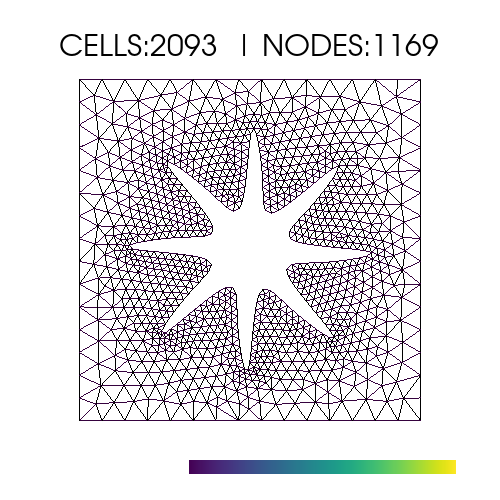

In [52]:
def plotmesh(mesh,cut):
    """ Plotting the mesh written by Gmsh

    parameters
    ---------
    mesh  - a gmsh.mesh object containting mesh info
    ct    - cell tegas
    
    output
    -------
    plotter - a pyvista.plotter object containing the mesh plot
    """
    V = FunctionSpace(mesh,('CG',1))
    v = Function(V)
    plotter = pyvista.Plotter(window_size=(500,500))
    grid = pyvista.UnstructuredGrid(*create_vtk_mesh(mesh, mesh.topology.dim))
    num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
    grid.cell_data["Marker"] = 1-ct.values[ct.indices<num_local_cells]
    grid.set_active_scalars("Marker")
    if cut:
        actor = plotter.add_mesh(grid, style='wireframe')
        plotter.set_background('white', top='white')
    else:
        plotter.add_mesh(grid, show_edges=True, line_width= 1, edge_color= 'w')
        plotter.set_background('black', top='black')
    plotter.view_xy()
    plotter.add_title('CELLS:'+str(ct.values.shape[0])+ '  | NODES:'+str(v.vector[:].shape[0]), color = 'k', font_size = 12)

    plotter.show()
    return plotter


plotter = plotmesh(mesh,cut)

### Define multi-point constraint for periodic BC

We now define the function to create the periodic boundary, taken from the `dolfinx-mpc` examples page. Note that we emplay standared periodic BCs here, not Floquet periodic BCs. We will introduce the Bloch ansatz in the weak form later on.

In [55]:
def dirichlet_and_periodic_bcs(
    domain: dolfinx.mesh.Mesh,
    functionspace: fem.FunctionSpace,
    bc_type: list[str] = ["periodic", "periodic"],
    dbc_value: ScalarType = 0,
):
    """Create periodic and/or Dirichlet boundary conditions for a square domain.

    Parameters
    ----------
    domain - mesh of a square unit cell
    functionspace - function space on which to apply the bcs
    bc_type - types of bc to apply on the left/right and top/bottom boundaries,
        respectively. Allowable values are "dirichlet" or "periodic"
    dbc_value - value of the Dirichlet bc
    """

    fdim = domain.topology.dim - 1
    bcs = []
    pbc_directions = []
    pbc_slave_tags = []
    pbc_is_slave = []
    pbc_is_master = []
    pbc_meshtags = []
    pbc_slave_to_master_maps = []

    def generate_pbc_slave_to_master_map(i):
        def pbc_slave_to_master_map(x):
            out_x = x.copy()
            out_x[i] = x[i] - domain.geometry.x.max()
            return out_x

        return pbc_slave_to_master_map

    def generate_pbc_is_slave(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.max())

    def generate_pbc_is_master(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.min())

    # Parse boundary conditions
    for i, bc_type in enumerate(bc_type):
        if bc_type == "dirichlet":
            u_bc = fem.Function(functionspace)
            u_bc.x.array[:] = dbc_value

            def dirichletboundary(x):
                return np.logical_or(
                    np.isclose(x[i], domain.geometry.x.min()),
                    np.isclose(x[i], domain.geometry.x.max()),
                )

            facets = locate_entities_boundary(domain, fdim, dirichletboundary)
            topological_dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
            bcs.append(fem.dirichletbc(u_bc, topological_dofs))

        elif bc_type == "periodic":
            pbc_directions.append(i)
            pbc_slave_tags.append(i + 2)
            pbc_is_slave.append(generate_pbc_is_slave(i))
            pbc_is_master.append(generate_pbc_is_master(i))
            pbc_slave_to_master_maps.append(generate_pbc_slave_to_master_map(i))

            facets = locate_entities_boundary(domain, fdim, pbc_is_slave[-1])
            arg_sort = np.argsort(facets)
            pbc_meshtags.append(
                dolfinx.mesh.meshtags(
                    domain,
                    fdim,
                    facets[arg_sort],
                    np.full(len(facets), pbc_slave_tags[-1], dtype=np.int32),
                )
            )

    # Create MultiPointConstraint object
    mpc = dolfinx_mpc.MultiPointConstraint(functionspace)

    N_pbc = len(pbc_directions)
    for i in range(N_pbc):
        if N_pbc > 1:

            def pbc_slave_to_master_map(x):
                out_x = pbc_slave_to_master_maps[i](x)
                idx = pbc_is_slave[(i + 1) % N_pbc](x)
                out_x[pbc_directions[i]][idx] = np.nan
                return out_x

        else:
            pbc_slave_to_master_map = pbc_slave_to_master_maps[i]

        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(
                functionspace,
                pbc_meshtags[i],
                pbc_slave_tags[i],
                pbc_slave_to_master_map,
                bcs,
            )
            print("MPC DEFINED (tag a)")
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(
                    functionspace.sub(i),
                    pbc_meshtags[i],
                    pbc_slave_tags[i],
                    pbc_slave_to_master_map,
                    bcs,
                )
                print("SUBSPACE MPC DEFINED (tag b)")

    if len(pbc_directions) > 1:
        # Map intersection(slaves_x, slaves_y) to intersection(masters_x, masters_y),
        # i.e. map the slave dof at (1, 1) to the master dof at (0, 0)
        def pbc_slave_to_master_map(x):
            out_x = x.copy()
            out_x[0] = x[0] - domain.geometry.x.max()
            out_x[1] = x[1] - domain.geometry.x.max()
            idx = np.logical_and(pbc_is_slave[0](x), pbc_is_slave[1](x))
            out_x[0][~idx] = np.nan
            out_x[1][~idx] = np.nan
            return out_x

        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(
                functionspace,
                pbc_meshtags[1],
                pbc_slave_tags[1],
                pbc_slave_to_master_map,
                bcs,
            )
            print("MPC DEFINED (tag c)")
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(
                    functionspace.sub(i),
                    pbc_meshtags[1],
                    pbc_slave_tags[1],
                    pbc_slave_to_master_map,
                    bcs,
                )
                print("SUBSPACE MPC DEFINED (tag d)")

    mpc.finalize()
    return mpc, bcs

## Solving the FEM Problem

We solve the Bloch-periodic Helmhotz equation by inserting Bloch-wave solutions of the form
$$
	{u}(\textbf{x},\textbf{k};t) = \tilde{{u}}e^{i(\textbf{k}\cdot\textbf{x} - \omega t)}
$$
into the periodic boundary value problem.
Defining a test function $\tilde{w}(\textbf{x},t)$ and trial function $\tilde{u}$, the weak for may be expressed as
$$
	E\int_{\Omega} \langle \nabla w,\nabla u\rangle{\rm d}\Omega = \rho\int_{\Omega}w\ddot{u}{\rm d}\Omega.
$$
We assume a test function  to be a Bloch-periodic scalar field, $w = \tilde{w}e^{i(\textbf{k}^\intercal\textbf{x}-\omega t)}$. Next, make use of the gradients of the Bloch-functions,
$$
	\nabla(u)  = \left(\nabla(\tilde{u}) + i\tilde{u}\textbf{k}  \right)e^{i(\textbf{k}^\intercal\textbf{x} -\omega t) }
$$
so that the variational equations take the form
$$
	E\int_{\Omega} 
	\left[ \nabla(\tilde{w}) + i\tilde{w}\textbf{k} \right]^{\dagger}
	\left[ \nabla(\tilde{u}) + i\tilde{u}\textbf{k}  \right]
	{\rm d} \omega
	=\rho \int_{\Omega}\tilde{w}^{\dagger}\ddot{u}{\rm d}\Omega.
$$


where the test function is also assumed to be a Bloch-periodic scalar field, $w = \tilde{w}e^{i(\textbf{k}^\intercal\textbf{x}-\omega t)}$.



In [57]:
# Assign function space, define trial/test functions
V = FunctionSpace(mesh,('CG',1))
mpc, bcs = dirichlet_and_periodic_bcs(mesh, V, ["periodic", "periodic"]) 
u_tr,u_test      = TrialFunction(V),TestFunction(V) 

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)


### Mass form


We set the weak form for mass first, since this does not depend on wave vector and therefor anly needs to be asembled once.
$$
\rho \int_{\Omega}\tilde{w}^{\dagger}\ddot{u}{\rm d}\Omega.
$$
 The following code evalutes the integral and assembles over each element,
$$
\mathbf{M} =	\overset{n_{el}}{\underset{e=1}{\rm \Large \bf \sf A}}  \int_{\Omega^e}  \rho\omega^2{\tilde{{w}}^e}^{\dagger}\tilde{{u}}^e {\rm d}\Omega^e  
$$
where ${ \bf \sf A}$ is the assembly operator and $n_{el}$ the number of elements in the mesh.


All we need to do is to define a function space and variational form, and then `dolfinx` along with `Petsc` will handel matrix assembly via `dolfinx-mpc.assemble_matrix()`.

We will also need a function to convert the `Petsc` object generated over the `dolfinx.fe.form` weak form into a `scipy.sparse.csr_matrix` csr array. We also require this sparse matrix to be of a complex data type to be compatible with the complex stiffness matrix.

In [59]:

def petsc_to_csr_complex(*args):
    """Converting a Petsc matrix to complex scipy csr array

    parameters
    -----------
    args:
        args[0] - assembled Petsc matrix containing real part of complex matrix
        args[1] - assembled Petsc matrix containing imaginary part of complex matrix

    returns
    ---------
    A complex scipy csr object. If only 1 arg is passed, then the imaginary values
    are set to 0 by default.
    """

    assert isinstance(args[0], PETSc.Mat)
    ai, aj, av = args[0].getValuesCSR()
    if len(args) > 1:
        assert isinstance(args[1], PETSc.Mat)
        _, _, av_im = args[1].getValuesCSR()
        return sparse.csr_matrix((av + 1j * av_im, aj, ai))
    else:
        return sparse.csr_matrix((av + 0j * av, aj, ai))
    
def mass_matrix_complex(u_tr, u_test, Rho, mpc, bcs):
    """Get the complex valued mass matrix

    parameters
    ----------
        u_tr - trial function
        u_test - test function
        Rho - Array of densities on mesh coords
        mpc - multi-point periodic constraint
        bcs - Dirichlet BCs

    returns
    -------
        Complex valued mass matrix is scipy csr format
    """

    m_form = Rho * dot(u_tr, u_test) * dx
    m = form(m_form)
    diagval_B = 1e-2
    B = dolfinx_mpc.assemble_matrix(m, mpc, bcs=bcs, diagval=diagval_B)
    B.assemble()
    return petsc_to_csr_complex(B)


Mcomp = mass_matrix_complex(u_tr, u_test, Rho, mpc, bcs)

### Stiffness form

Now write a function to assemble the stiffness matrix and solve the sysetm for a given set of wavector coordinates. We split the bilinear form into real and imaginary parts, and assemble, and the recombine to solve the complex problem.
$$
	\mathcal{A}(\tilde{u},\tilde{w}) = [  \nabla (\tilde{w} ) + i\tilde{w}\textbf{k} ]^{\dagger}[\nabla(\tilde{u}) - i\tilde{u}\textbf{k}]
$$
We can now readily separate out the real and imaginary parts, and recast-them into bilinear forms amenable to `fenicsx` assembly operations.
$$	\mathcal{A}(\tilde{u},\tilde{w}) = (\nabla\tilde{w}\cdot\nabla\tilde{u} + \tilde{w}\tilde{u}(k_1+k_2)) + i [\tilde{w}(\nabla\tilde{u}\cdot\textbf{k})
	- \tilde{u} (\nabla\tilde{w}\cdot\textbf{k}) ]
$$
Accodingly, the weak form can be split sa
$$
	\int_{\Omega}\mathcal{A}(\tilde{u},\tilde{w}){\rm d}\Omega = 
	\int_{\Omega} {\rm Re}\left(\mathcal{A}(\tilde{u},\tilde{w})\right){\rm d}\Omega 
	+
	i\int_{\Omega} {\rm Im}\left(\mathcal{A}(\tilde{u},\tilde{w})\right){\rm d}\Omega 
$$
From hereon, we perform assembly in \texttt{dolfinx} by considering the real-valued matrices $\textbf{K}_r\in\mathbb{R}^{N\times N}$  and $\textbf{K}_i$, and then reintroduce the complex-valued stiffness matrix after the assembly operations via $\textbf{K} = \textbf{K}_r+ i\textbf{K}_i \in\mathbb{C}^{N\times N}$ leading to a complex-valued Bloch eigenvalue problem that can be solved by converting the `PETSc` objects into alternative forms that are amenable for complex operations. This avoids any issues that might be caused by `Petsc` builds that are incompatible with complex numbers. Hence, we call 	`dolfinx-mpc.assemble_matrix()` for both the real an imaginary compoents of the weak form:
\begin{align*}
	&\textbf{K}_r(\textbf{k}) = 
	\overset{n_{el}}{\underset{e=1}{\rm \Large \bf \sf A}}    \int_{\Omega^e} {\rm Re} \left[\mathcal{A}(\tilde{\mathbf{u}}^e,\tilde{\mathbf{w}}^e)\right] {\rm d}\Omega^e \\
	&\textbf{K}_i(\textbf{k}) = 
	\overset{n_{el}}{\underset{e=1}{\rm \Large \bf \sf A}}    \int_{\Omega^e} {\rm Im } \left[\mathcal{A}(\tilde{\mathbf{u}}^e,\tilde{\mathbf{w}}^e)\right] {\rm d}\Omega^e 
\end{align*}
Finally, reintroducing the mass matrix that was assembled prior, we have the complete Bloch eigenproblem
$$
	\left(\tilde{\textbf{K}}_r+i\tilde{\textbf{K}}_i - \omega^2\textbf{M}\right)\tilde{\mathbf{u}} = \textbf{0}
$$
which can be numerically solved using `scipy`'s sparse linear algebra package based on the `ARPACK` library.


In [60]:
def solve_system(
    kx: float,
    ky: float,
    E: float,
    Mcomp: PETSc.Mat,
    mpc: dolfinx_mpc.MultiPointConstraint,
    bcs: list[dolfinx.fem.dirichletbc],
    n_solutions: int,
    mesh: dolfinx.mesh.Mesh,
    u_tr: Argument,
    u_test: Argument,
):
    """Assemble and solve dispersion at a single wavevector point.

    Parameters
    ----------
    kx - x-component of the wavevector
    ky - y-component of the wavevector
    E - modulus
    Mcomp - mass matrix
    mpc - multi-point constraint holding the periodic bcs
    bcs - Dirichlet bcs
    n_solutions - number of eigenvalue/eigenvector pairs to compute
    mesh - mesh of the unit cell
    u_tr - trial function
    u_test - test function
    """

    # Define the bilinear weak form
    K = fem.Constant(mesh, ScalarType((kx, ky)))
    kx = fem.Constant(mesh, ScalarType(kx))
    ky = fem.Constant(mesh, ScalarType(ky))
    a_form_re = (
        E * (inner(grad(u_tr), grad(u_test)) + u_tr * u_test * (kx**2 + ky**2))
        * dx
    )
    a_form_im = (
        E * (u_tr * inner(grad(u_test), K) - u_test * inner(grad(u_tr), K)) * dx
    )
    a_re = form(a_form_re)
    a_im = form(a_form_im)

    # Assemble Solve the eigenproblem
    diagval_A = 1e6
    A_re = dolfinx_mpc.assemble_matrix(a_re, mpc, bcs=bcs, diagval=diagval_A)
    A_im = dolfinx_mpc.assemble_matrix(a_im, mpc, bcs=bcs, diagval=diagval_A)
    A_re.assemble()
    A_im.assemble()
    Kcomp = petsc_to_csr_complex(A_re, A_im)
    eval, evec = eigsh(Kcomp, M=Mcomp, k=n_solutions, sigma=0.1)
    return eval, evec


### Testing our the solver

Define a pair of $(k_x,k_y)$ coordinates, the number of eigensolutions, the trial and test functions, and plot the eigenfrequencies recovered for the first `n_solutions`.

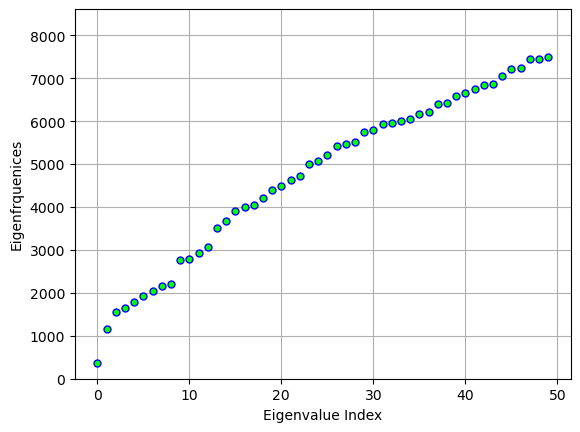

In [98]:
ky = 0
kx = np.pi/a_len/2
n_solutions = 50

eval, evec = solve_system(
    kx = kx,
    ky = ky,
    E = E,
    Mcomp = Mcomp,
    mpc = mpc,
    bcs = bcs,
    n_solutions = n_solutions, 
    mesh = mesh, 
    u_tr = u_tr, 
    u_test = u_test
)

eigfrq_sp_cmp = np.real(eval)**.5
eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )

plt.plot(eigfrq_sp_cmp,'.', c = (0,1,0), markersize = 10, markeredgecolor = (0,0,1))
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenfrquenices')
plt.ylim((0,eigfrq_sp_cmp.max()*1.15))
plt.grid()


### Computing the band structure

To recover a band strucutre, we need to recovrer the Bloch eigensolutions over a range of wavevectors that loops around the perimiter of the IBZ. In teh case of rotationaly 4-quad symmetry, this boundary is defined by the $\Gamma$-$X$-$M$-$\Gamma$ high-symmety points. Hence, solving the system in a loop around these points gives a list of eiensolutions that when agregated can represent the band stucture.

In [99]:

# Setting the high symmetr points
P1 = [0, 0]  # Gamma
P2 = [np.pi / a_len, 0]  # X
P3 = [np.pi / a_len, np.pi / a_len]  # K
HSpts = [P1, P2, P3, P1]
HSstr = ["Γ", "X", "M", "Γ"]

n_wavevector = 60
n_solutions = 20;

# Intitialize loop params
nvec_per_HS = int(round(n_wavevector / len(HSpts)))
evals_disp, evecs_disp = [], []
start = time.time()
KX, KY = [], []
kx, ky = HSpts[0][0], HSpts[0][1]
KX.append(kx)
KY.append(ky)

if ScalarType == np.float64:
    # Make mass matrix
    Mcomp = mass_matrix_complex(u_tr, u_test, Rho, mpc, bcs)

    # Loop to compute band structure
    print("Computing Band Structure... ")
    for k in range(len(HSpts) - 1):
        print("Computing " + str(HSstr[k]) + " to " + str(HSstr[k + 1]))
        slope = np.array(HSpts[k + 1]) - np.array(HSpts[k])
        nsolve = nvec_per_HS
        for j in range(nsolve):
            kx = kx + slope[0] / nvec_per_HS
            ky = ky + slope[1] / nvec_per_HS
            ky = 0 if np.isclose(ky, 0) else ky
            kx = 0 if np.isclose(kx, 0) else kx
            KX.append(kx)
            KY.append(ky)
            eval, evec = solve_system(
                kx, ky, E, Mcomp, mpc, bcs, n_solutions, mesh, u_tr, u_test
            )
            eval[np.isclose(eval, 0)] == 0
            eigfrq_sp_cmp = np.abs(np.real(eval)) ** 0.5
            eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp)
            evals_disp.append(eigfrq_sp_cmp)
            evecs_disp.append(evec)

    t2 = round(time.time() - start, 3)

    print("Time to compute dispersion " + str(t2))
    print("Band computation complete")
    print("-----------------")
    print("N_dof...." + str(ct.values.shape[0]))
    print("N_vectors...." + str(n_solutions))
    print("N_wavenumbers...." + str(n_wavevector))
    print("T total...." + str(round(t2, 3)))

Computing Band Structure... 
Computing Γ to X
Computing X to M
Computing M to Γ
Time to compute dispersion 1.737
Band computation complete
-----------------
N_dof....2093
N_vectors....20
N_wavenumbers....60
T total....1.737


### Post-processing the eigensolutions

We can now check for band gaps by computing the differnce between eigenfrequency branches and filtering out the artificial band gaps introduced by the discretization of our Brillouin zone from true band gaps. We can also *normalize* the band gaps with respect the their center frequency (this allows for a direct comparison of the relative width of high and low frequency band gaps.)

In [100]:
def getbands(bands):
    """Getting the band-gaps from a dispersion diagram

    input:
        bands - an np array storing eigensolutions across wavevectors

    output:
        BG_normalized - normalized band gap widthds
        gapwidths   - spacing between bands (not necessarly band gap)
        gaps        - un-normalized band gap widths
                      (filtered to ensure the gap is not a
                      numerical artificat)
        lowbounds   - frequencies of the lower bounds of band gaps
        highbounds  - frequencies of the higher bounds of band gaps
    """
    nvec = bands.shape[1]
    nK = bands.shape[0]
    ef_vec = bands.reshape((1, nvec * nK))
    evals_all = np.sort(ef_vec).T
    deval = np.diff(evals_all.T).T
    args = np.flip(np.argsort(deval.T)).T

    # Finding the boundaries of the pass bands
    lowb, uppb, lowlim, uplim, bgs = [], [], [], [], []
    for k in range(nvec):
        lowb.append(np.min(bands.T[k]))
        uppb.append(np.max(bands.T[k]))
    for k in range(nvec):
        LowerLim = np.max(bands[:, k])
        if k < nvec - 1:
            UpperLim = np.min(bands[:, k + 1])
        else:
            UpperLim = np.min(bands[:, k])

        # Check if these limits fall in a pass band
        overlap = False
        for j in range(nvec):
            if LowerLim > lowb[j] and LowerLim < uppb[j]:
                overlap = True
            if UpperLim > lowb[j] and UpperLim < uppb[j]:
                overlap = True
        if overlap == False:
            lowlim.append(LowerLim)
            uplim.append(UpperLim)
            bgs.append(UpperLim - LowerLim)

    # Filter band gaps
    maxfq = np.max(bands[:])
    isgap = [i for i, v in enumerate(bgs) if v > np.median(deval)]
    gaps = np.array(bgs)
    lower = np.array(lowlim)
    higher = np.array(uplim)
    gapwidths = gaps[isgap]
    lowbounds = lower[isgap]
    highbounds = higher[isgap]
    BG_normalized = gapwidths / (0.5 * lowbounds + 0.5 * highbounds)

    return BG_normalized, gapwidths, gaps, lowbounds, highbounds

### Plotting the eigensolutions

Once we have defined a function to return our band gaps, we can plot everything together and shade in the band-gap regions in green. We can also plot out the path that the solutiosn were computed over the IBZ by utilizing the list of $(k_X,k_y)$ pairs recovered during the band strcuture computaitons.

<module 'matplotlib.pyplot' from '/home/jrt7/anaconda3/envs/fenicsx-env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

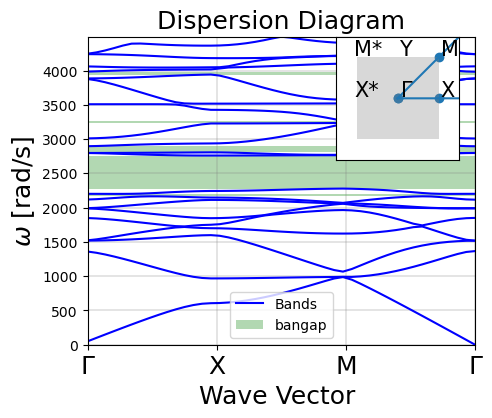

In [101]:
def plotbands(
    bands: np.array = None,
    HSpts: list = None,
    HS_labels: list = None,
    inset: bool = False,
    KX: list = None,
    KY: list = None,
    a_len: float = 1.0,
    figsize: tuple = (5, 4),
):
    """Plotting the dispersion bands

    Paramters
    ---------
        bands - A numpy array containing all eigensolutions at each wavenumber
        HSpts - A list of the numeric values of high-symmetry points solvded fro
        HS_labels - The labels of the high-symmetry points
        inset -  whetehr or not to plot the path along the IBZ in the inset (based on KX, KY)
        KX - The kx-wavevectors visited in the disperison computaiton (a list of points)
        KY - The ky-wavevectors visited in the disperison computaiton (a list of points)
        figsize - A tuple for the figure size. (5,4) is default

    output
    --------
        plt - The matplotlib.pyplot object
    """

    bgnrm, gapwidths, gaps, lowbounds, highbounds = getbands(bands)

    plt.figure(figsize=figsize)

    # Default assumes a G-X-M-G boundary
    if HS_labels == None:
        HS_labels = ["Γ", "X", "M", "Γ"]

    if HSpts == None:
        # Setting the high symmetr points
        P1 = [0, 0]  # Gamma
        P2 = [np.pi / a_len, 0]  # X
        P3 = [np.pi / a_len, np.pi / a_len]  # K
        HSpts = [P1, P2, P3, P1]
        HSstr = ["Γ", "X", "M", "Γ"]

    # Get number of solutions inbetween HS points
    nsol = bands.shape[0]
    nvec = bands.shape[1]
    nvec_per_HS = int(round(nsol / len(HS_labels) + 1))
    xx = np.linspace(0, 1, nsol)

    # PLOT THE DISPERSION BANDS
    for n in range(nvec):
        if n == 0:
            plt.plot(xx, (bands[:, n]), "b.-", markersize=0, label="Bands")
        if n > 0:
            plt.plot(xx, (bands[:, n]), "b.-", markersize=0)

    # Plot the band gaps
    currentAxis = plt.gca()
    for j in range(len(gapwidths)):
        lb = lowbounds[j]
        ub = highbounds[j]
        if j == 0:
            currentAxis.add_patch(
                Rectangle(
                    (np.min(xx), lb),
                    np.max(xx),
                    ub - lb,
                    facecolor="g",
                    ec="none",
                    alpha=0.3,
                    label="bangap",
                )
            )
        else:
            currentAxis.add_patch(
                Rectangle(
                    (np.min(xx), lb),
                    np.max(xx),
                    ub - lb,
                    facecolor="g",
                    ec="none",
                    alpha=0.3,
                )
            )

    # Plot formatting
    plt.grid(color="gray", linestyle="-", linewidth=0.3)
    plt.xticks(np.linspace(0, xx.max(), len(HS_labels)), HS_labels, fontsize=18)
    plt.xlabel(r"Wave Vector ", fontsize=18)
    plt.ylabel("$\omega$ [rad/s]", fontsize=18)
    plt.title("Dispersion Diagram", fontsize=18)
    plt.xlim((0, xx.max()))
    plt.ylim((0, bands.max()))
    plt.legend()

    # Inset for the IBZ
    if inset:
        ax = plt.gca()
        ax2 = ax.inset_axes([0.6, 0.6, 0.4, 0.4])
        ax2.plot(np.array(KX) * a_len / np.pi, np.array(KY) * a_len / np.pi)
        ax2.scatter(
            np.array(HSpts)[:, 0] * a_len / np.pi, np.array(HSpts)[:, 1] * a_len / np.pi
        )
        ax2.text(0.05, 0.05, "$\Gamma$", fontsize=15)
        ax2.text(1.05, 0.05, "X", fontsize=15)
        ax2.text(1.05, 1.05, "M", fontsize=15)
        ax2.text(0.05, 1.05, "Y", fontsize=15)
        ax2.text(-1.05, 0.05, "X*", fontsize=15)
        ax2.text(-1.05, 1.05, "M*", fontsize=15)
        ax2.add_patch(Rectangle((-1, -1), 2, 2, facecolor="gray", ec="none", alpha=0.3))
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.axis("square")
        ax2.set_alpha(0.2)
        ax2.set_xlim((-1.5, 1.5))
        ax2.set_ylim((-1.5, 1.5))

    return plt

plotbands(np.array(evals_disp), KX =KX, KY = KY, inset = True)

### Visualize the eigenvectors

We can utilize `pyvista` to visualize the eigensolutions. We ust also implement the `dolfinx-mpc` `backscatter` function to account the the condensation of the system's DoFs when applying a periodic boundary so that the solutiosn can be viewed on the original DoF map.

  mycmap = plt.cm.get_cmap(cmap, nmap)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



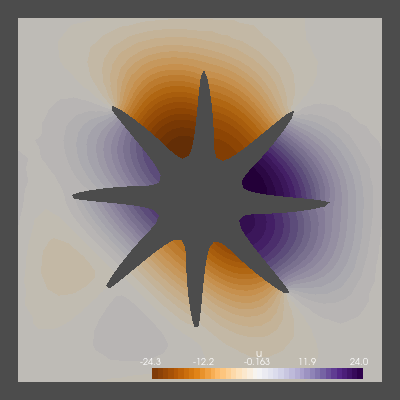

In [112]:
def plotvecs(
    plotter: pyvista.Plotter = None,
    V: dolfinx.fem.FunctionSpace = None,
    mpc: dolfinx_mpc.MultiPointConstraint = None,
    evecs: np.array = None,
    eval_number: int = 1,
    wavevec_number: int = 1,
    cmap: str = "bwr",
    nmap: int = 50,
):
    """Plotting the eigenvectors of the dispersion problem

    inputs:
            plotter: Pyvista plotter object (pv.plotter)
            V: Function space (defined over mesh using dolfinx.fem.FunctoinSpace())
            mpc: Multi-point constraint for periodic BVP
            evecs: An numpy of dim [i x j x k]
                    i Number of wavevectors solved for
                    j Number of Dofs in unit cell
                    k Number of evals solved per wavenumber
            eval_number: The eigenvalue number to plot (i)
            wavevec_number: The wavevector index to plot (k)

    outputs:
            plotter:        The plotter object is returned with the eigenvector visual
                            stored on the object. Use plotter.show() after calling function
                            to view.

    """

    # Post-processing the -vecs
    data = np.array(evecs)
    et = data[wavevec_number, :, eval_number]
    vr = dolfinx.fem.Function(V)
    vi = dolfinx.fem.Function(V)
    vr.vector[:] = np.real(et)  # / np.max( np.real(et))
    vi.vector[:] = np.imag(et)  # / np.max( np.real(et))
    vr.x.scatter_forward()
    mpc.backsubstitution(vr.vector)
    vi.x.scatter_forward()
    mpc.backsubstitution(vi.vector)

    # Plotting eigenvectors with pyvista
    mycmap = plt.cm.get_cmap(cmap, nmap)
    u = dolfinx.fem.Function(V)
    cells, types, x = plot.create_vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    u.vector.setArray(vr.vector[:])
    grid.point_data["u"] = u.x.array
    edges = grid.extract_all_edges()
    warped = grid.warp_by_scalar("u", factor=0)
    plotter.add_mesh(
        warped, show_edges=False, show_scalar_bar=True, scalars="u", cmap=mycmap
    )
    plotter.view_xy()
    plotter.camera.tight(padding=0.1)

    return plotter

# Initialize the pyvista plotter
plotter = pyvista.Plotter(shape=(1,1) , window_size=(400,400))

# Set the eigenvalue and  wavenumber to plot over
eval_number = 4
wavevec_number = 30
fspace = 'CG'
V = dolfinx.fem.FunctionSpace(mesh,(fspace,1))
plotter = plotvecs(
    plotter = plotter , 
    V = V, mpc = mpc, 
    evecs = evecs_disp, 
    eval_number = eval_number,
    wavevec_number = wavevec_number,
    cmap = 'PuOr',
    nmap = 40
)
plotter.show()

We can now see how the eigenvectors evlove around the IBZ